In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
# Useful functions
def to_col(x):   
    if len(x.shape)==1:
        x=x.reshape(x.shape[0],1)
    return x

def to_line(x):
    """ convert an vector to line vector if needed """
    if len(x.shape)==1:
        x=x.reshape(1,x.shape[0])
    return x

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[np.squeeze(labels==l),0],data[np.squeeze(labels==l),1],c=cols[i],marker=marks[i])
        

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])


## Chargement des données

In [3]:
A_train = np.loadtxt('classification_data_HWK1/classificationA.train')
B_train = np.loadtxt('classification_data_HWK1/classificationB.train')
C_train = np.loadtxt('classification_data_HWK1/classificationC.train')
A_test = np.loadtxt('classification_data_HWK1/classificationA.test')
B_test = np.loadtxt('classification_data_HWK1/classificationB.test')
C_test = np.loadtxt('classification_data_HWK1/classificationC.test')

In [4]:
# Load tous les X_A_train,Y_A_train,X_B_train,Y_B_train ...
for cas in ["A","B","C"]:
    for type_set in ["train","test"]:
        exec("X_"+cas+"_"+type_set+"="+cas+"_"+type_set+"[:,0:2]")
        exec("Y_"+cas+"_"+type_set+"=to_col("+cas+"_"+type_set+"[:,2])")

## 2. MLE Generative model (LDA)

In [11]:
def theta_MLE(Y):
    return(np.sum(Y)/Y.shape[0])

def mu_1_MLE(X,Y):
    return([np.sum(Y*to_col(X[:,0]))/np.sum(Y), np.sum(Y*to_col(X[:,1]))/np.sum(Y)])

def mu_0_MLE(X,Y): 
    return([(np.sum(X[:,0]) - np.sum(Y*to_col(X[:,0])))/(Y.shape[0]-np.sum(Y)), 
            (np.sum(X[:,1]) - np.sum(Y*to_col(X[:,1])))/(Y.shape[0]-np.sum(Y))])

def sigma_MLE(X,Y): 
    s1 = np.dot(np.transpose(Y)*np.transpose(X-mu_1_MLE(X,Y)),(X-mu_1_MLE(X,Y)))
    s0 = np.dot((np.ones(Y.shape[0])-np.transpose(Y))*np.transpose(X-mu_0_MLE(X,Y)),(X-mu_0_MLE(X,Y)))
    return((s1+s0)/Y.shape[0])

def compute_a(X,Y):
    return(np.dot(np.linalg.inv(sigma_MLE(X,Y)),np.asarray(mu_1_MLE(X,Y))-np.asarray(mu_0_MLE(X,Y))))

def compute_b(X,Y):
    return(np.log(theta_MLE(Y)/(1-theta_MLE(Y))) 
           -1/2*np.dot(np.dot((np.asarray(mu_1_MLE(X,Y))-np.asarray(mu_0_MLE(X,Y))),np.linalg.inv(sigma_MLE(X,Y)))
                ,(np.asarray(mu_0_MLE(X,Y))+np.asarray(mu_1_MLE(X,Y)))))


def LDA_prediction(x,a,b):
    return to_col(np.array([np.dot(a,x)+b>=0 for x in X_A_test]))

def error(predicted,real_values):
    number_of_missclassified = np.sum(np.abs(predicted-Y_A_test))
    percentage_error = number_of_missclassified/float(real_values.shape[0])
    return number_of_missclassified,percentage_error

def sigmoid(X):  #fonction sigmoide pour la proba conditionnelle
    return (1/(1+np.exp(-X)))
def LDA(x,a,b):
    return(sigmoid(np.dot(a)*x+b))

#### Compute MLE parameters

In [12]:
# definie a_A, a_B, a_c, b_A, ...
for cas in ["A","B","C"]:
    for parameters in ["a","b"]:
        exec(parameters+"_"+cas+"=compute_"+parameters+"(X_"+cas+"_train,Y_"+cas+"_train)")
        

    print("theta_"+cas+"=",eval("theta_MLE(Y_"+cas+"_train)"))
    print("mu_1_"+cas+"=",eval("mu_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("mu_0_"+cas+"=",eval("mu_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_"+cas+"=",eval("sigma_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("a_"+cas+"=", eval("a_"+cas))
    print("b_"+cas+"=", eval("b_"+cas))
    print
    print

('theta_A=', 0.33333333333333331)
('mu_1_A=', [-2.6923200424, 0.86604200000000031])
('mu_0_A=', [2.8997094650999999, -0.89387399999999995])
('sigma_A=', array([[ 2.44190897, -1.13194024],
       [-1.13194024,  0.61375465]]))
('a_A=', array([-6.62245258, -9.3462503 ]))
('b_A=', -0.6931471805599454)


('theta_B=', 0.5)
('mu_1_B=', [-3.2167073426666648, 1.0830673333333332])
('mu_0_B=', [3.3406889640666675, -0.83546333333333356])
('sigma_B=', array([[ 3.34623467, -0.13516489],
       [-0.13516489,  1.73807475]]))
('a_B=', array([-1.92108197,  0.95442836]))
('b_B=', 0.0)


('theta_C=', 0.625)
('mu_1_C=', [-2.9423288508399987, -0.95782840000000002])
('mu_0_C=', [2.7930482375999981, -0.83838666666666595])
('sigma_C=', array([[ 2.88039225, -0.63405081],
       [-0.63405081,  5.19952435]]))
('a_C=', array([-2.05129911, -0.27311529]))
('b_C=', 0.51082562376599072)




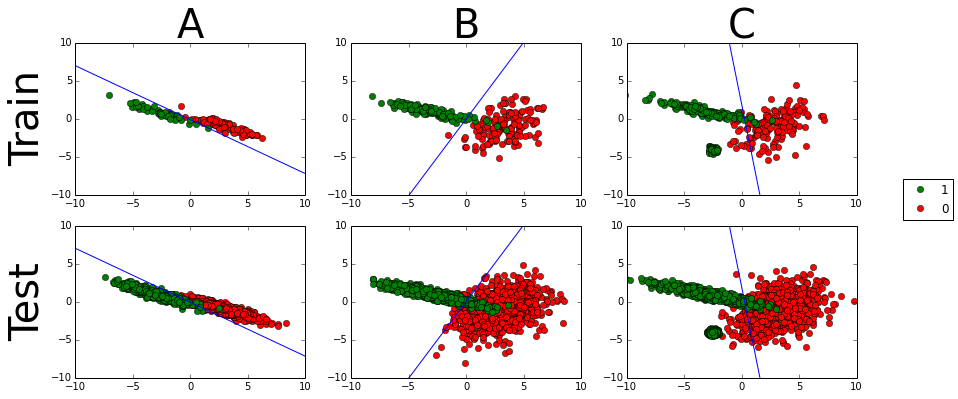

In [24]:
plt.rcParams['figure.figsize'] = (14, 6)
fig, axes = plt.subplots(2, 3)
axes[0][0].set_title("A",fontsize="40") 
axes[0][1].set_title("B",fontsize="40")
axes[0][2].set_title("C",fontsize="40")
axes[0][0].set_ylabel("Train",fontsize="40")
axes[1][0].set_ylabel("Test",fontsize="40")

Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        # Affichage des données
        axes[Sets.index(s)][Cases.index(cas)].set_xlim(-10,10)
        axes[Sets.index(s)][Cases.index(cas)].set_ylim(-10,10)
        exec("X_"+cas+"_0 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==0)]")
        exec("X_"+cas+"_1 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==1)]")
        exec("red, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_0[:,0],X_"+cas+"_0[:,1],'ro')")
        exec("green, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_1[:,0],X_"+cas+"_1[:,1],'go')")
        
    # Affichage de la ligne de p(Y=1|X)
    a = eval("a_"+cas)
    b = eval("b_"+cas)
    x1 = np.linspace(-10,10)
    x2= (-a[0]*x1-b)/a[1]
    axes[0][Cases.index(cas)].plot(x1,x2,'b')
    axes[1][Cases.index(cas)].plot(x1,x2,'b')
fig.legend((green,red),('1', '0'),'center right',numpoints = 1)
plt.show()

In [34]:
#calcul de l'erreur
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        a = eval("a_"+cas)
        b = eval("b_"+cas)
        x = eval("X_"+cas+"_"+s)
        predicted = LDA_prediction(x,a,b)
        real_values = eval("Y_"+cas+"_"+s)
        number_of_missclassified,percentage_error = error(predicted,real_values)
        print cas+" "+s+" : "+str(int(number_of_missclassified))+" points mal classifiés soit"+str(percentage_error)+" % d'erreur"
    print     

A train : 30 points mal classifiés soit0.2 % d'erreur
A test : 30 points mal classifiés soit0.02 % d'erreur

B train : 46 points mal classifiés soit0.153333333333 % d'erreur
B test : 46 points mal classifiés soit0.023 % d'erreur

C train : 52 points mal classifiés soit0.13 % d'erreur
C test : 52 points mal classifiés soit0.0173333333333 % d'erreur



In [ ]:
### JE ME SUIS ARRETE LA

In [36]:
sigmoid(np.dot(X_A_train,a_sigmoid(X_A_train,Y_A_train))+b_sigmoid(X_A_train,Y_A_train))
np.dot(X_A_train,a_sigmoid(X_A_train,Y_A_train))
sigmoid(X_A_train*a_sigmoid(X_A_train,Y_A_train)+b_sigmoid(X_A_train,Y_A_train))

NameError: name 'a_sigmoid' is not defined

#### Sample B

In [184]:
print("theta =",theta_MLE(Y_B_train))
print("mu_1 =",mu_1_MLE(X_B_train,Y_B_train))
print("mu_0 =",mu_0_MLE(X_B_train,Y_B_train))
print("sigma =",sigma_MLE(X_B_train,Y_B_train))
print("a =", a_sigmoid(X_B_train,Y_B_train))
print("b =", b_sigmoid(X_B_train,Y_B_train))

theta = 0.5
mu_1 = [-3.2167073426666666, 1.0830673333333334]
mu_0 = [3.340688964066667, -0.83546333333333334]
sigma = [[ 3.34623467 -0.13516489]
 [-0.13516489  1.73807475]]
a = [-1.92108197  0.95442836]
b = 0.000929288716542


#### Sample C

In [185]:
print("theta =",theta_MLE(Y_C_train))
print("mu_1 =",mu_1_MLE(X_C_train,Y_C_train))
print("mu_0 =",mu_0_MLE(X_C_train,Y_C_train))
print("sigma =",sigma_MLE(X_C_train,Y_C_train))
print("a =", a_sigmoid(X_C_train,Y_C_train))
print("b =", b_sigmoid(X_C_train,Y_C_train))

theta = 0.625
mu_1 = [-2.9423288508400001, -0.95782840000000014]
mu_0 = [2.7930482376000003, -0.8383866666666665]
sigma = [[ 2.88039225 -0.63405081]
 [-0.63405081  5.19952435]]
a = [-2.05129911 -0.27311529]
b = 0.112429132177


## 5. QDA model

In [ ]:
def sigma_0_MLE(X,Y):
    s0 =np.dot((np.ones(Y.shape[0])-np.transpose(Y))*np.transpose(X-mu_0_MLE(X,Y)),(X-mu_0_MLE(X,Y)))
    return(s0/(Y.shape[0]-np.sum(Y)))

def sigma_1_MLE(X,Y):
    s1 = np.dot(np.transpose(Y)*np.transpose(X-mu_1_MLE(X,Y)),(X-mu_1_MLE(X,Y)))
    return(s1/np.sum(Y))







def c_sigmoid(X,Y):
    return(np.dot(np.linalg.inv(sigma_1_MLE(X,Y)),np.asarray(nu_1_MLE(X,Y)))
           -np.dot(np.linalg.inv(sigma_0_MLE(X,Y)),np.asarray(nu_0_MLE(X,Y)))
           
           
           
           np.asarray(nu_0_MLE(X,Y))))

def d_sigmoid(X,Y):
    return(np.log(theta_MLE(Y)/(1-theta_MLE(Y))) 
           -1/2*np.dot(np.dot((np.asarray(nu_1_MLE(X,Y))-np.asarray(nu_0_MLE(X,Y))),np.linalg.inv(sigma_MLE(X,Y)))
                ,(np.asarray(nu_0_MLE(X,Y))+np.asarray(nu_1_MLE(X,Y)))))

def M_sigmoid(X,Y):
    return(np.dot(np.linalg.inv(sigma_MLE(X,Y)),np.asarray(nu_1_MLE(X,Y))-np.asarray(nu_0_MLE(X,Y))))



(150, 2)


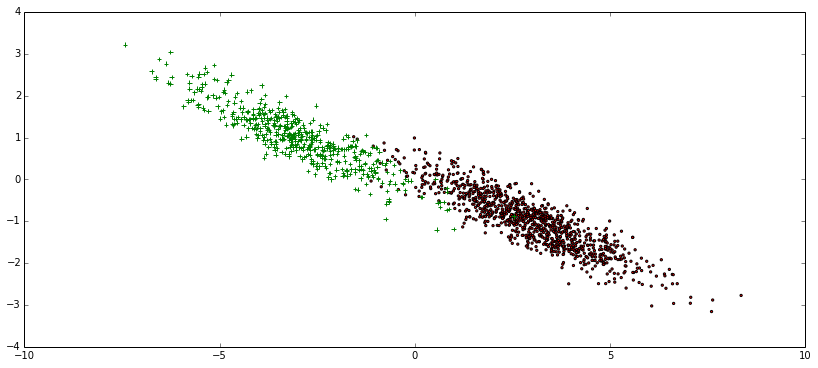

In [40]:
print np.shape(X_A_train)

plot_data(X_A_test,Y_A_test)

In [122]:
#LDA(X_A_train, Y_A_train)

In [ ]:
Theta_MLE_A = (1.0/np.shape(A_train)[0])*sum([a[2] for a in A_train])
Theta_MLE_B = (1.0/np.shape(B_train)[0])*sum([b[2] for b in B_train])
Theta_MLE_C = (1.0/np.shape(C_train)[0])*sum([c[2] for c in C_train])

print Theta_MLE_A
print Theta_MLE_B
print Theta_MLE_C

mu_0_MLE_A = np.sum([(1-a[2])*np.array([a[0],a[1]]) for a in A_train],axis = 0)/sum([(1-a[2]) for a in A_train])
mu_0_MLE_B = np.sum([(1-b[2])*np.array([b[0],b[1]]) for b in B_train],axis = 0)/sum([(1-b[2]) for b in B_train])
mu_0_MLE_C = np.sum([(1-c[2])*np.array([c[0],c[1]]) for c in C_train],axis = 0)/sum([(1-c[2]) for c in C_train])

print mu_0_MLE_A
print mu_0_MLE_B
print mu_0_MLE_C

mu_1_MLE_A = np.sum([a[2]*np.array([a[0],a[1]]) for a in A_train],axis = 0)/sum([a[2] for a in A_train])
mu_1_MLE_B = np.sum([b[2]*np.array([b[0],b[1]]) for b in B_train],axis = 0)/sum([b[2] for b in B_train])
mu_1_MLE_C = np.sum([c[2]*np.array([c[0],c[1]]) for c in C_train],axis = 0)/sum([c[2] for c in C_train])

print mu_1_MLE_A
print mu_1_MLE_B
print mu_1_MLE_C

def p_Y1_X(x,theta,mu_0,mu_1,sigma):#x vecteur vertical
    return( 1.0/(1.0+((1.0-theta)/(theta))*exp((((mu_0+mu_1)[np.newaxis]).T).dot(sigma).dot(x) - (1.0/2)*((mu_0.T).dot(sigma).dot(mu_0) + (mu_1.T).dot(sigma).dot(mu_1))))
    

In [ ]:
print A_train[:3]

In [ ]:
print [np.array([a[0],a[1]]) for a in A_train][:2]

In [ ]:
a = np.array([1,2])
b = np.array([[3,4],[5,6]])
print np.transpose(a[np.newaxis])*b

In [ ]:
#transformer un vecteur ligne en colone
vecteur_ligne = np.array([1,2,3])
vecteur_colone = np.transpose(vecteur_ligne[np.newaxis])
print vecteur_ligne
print np.transpose(vecteur_colone).dot(np.array([[1,2,0],[0,1,0],[0,0,1]])).dot(vecteur_colone)

print vecteur_colone.T

array([[-3.60340505,  1.3266    ,  1.        ],
       [-4.2190114 ,  2.015     ,  1.        ],
       [-1.51565812,  0.5059    ,  1.        ],
       [-1.16975695,  0.3815    ,  1.        ],
       [ 0.52274116, -0.6572    ,  1.        ],
       [-0.14174035, -0.7083    ,  1.        ],
       [-3.2644966 ,  1.312     ,  1.        ],
       [-1.7093627 ,  0.2236    ,  1.        ],
       [-2.06451872,  0.6392    ,  1.        ],
       [-2.7745778 ,  1.139     ,  1.        ],
       [-4.4637327 ,  1.2861    ,  1.        ],
       [-2.05557939,  0.716     ,  1.        ],
       [-4.93081485,  1.9442    ,  1.        ],
       [-2.78573378,  0.8165    ,  1.        ],
       [-3.78492412,  1.0945    ,  1.        ],
       [-0.023503  , -0.1801    ,  1.        ],
       [-4.0787268 ,  1.6789    ,  1.        ],
       [-4.88879174,  2.2006    ,  1.        ],
       [-4.11260798,  1.3405    ,  1.        ],
       [-5.11303227,  1.578     ,  1.        ],
       [-2.76271871,  0.6868    ,  1.   

In [88]:
cas = "toto"
exec("X_"+cas+"_train = "+cas+"_train[:,0:2]")


NameError: name 'toto_train' is not defined